## Experiments in 'Tonal Complexity'

Prepared by Martin Disley, Feb. 2018

Here I present my initial experimentation in computational aesthetics in music. The goal of the following experiment was to attempt to separate what we would broadly call 'musical sounds' from 'non-musical synthetic sounds'. 

The hypothesis here is that our perceptual (subconscious) classification of sound as 'musical' or sound that we consider holds aesthetic value necessitates encoding of the data. In other words, sound that is too complex to encode we find holds little aesthetic value. On the other hand, we also find that sound that is overly simple and presents no challenge to be encoded also hold little aesthetic value. It is, therefore, reasonable to infer that there lies a 'sweet spot'.  

Here I investigate two features that could be representative of complexity in sound, Spectral Complexity; the number of peaks present in the magnitude spectrum, and the Harmonic Complexity; a value of dissonance/consonance found by calculating deviation in spectral peaks from the integer multiples of their fundamental. The 'sweet spot' here would sounds that are consonant but complex; they are complex enough to be considered interesting, but consonant enough to be optimally encoded. The implementation uses the Essentia functions to estimate their 'Spectral Complexity' and Dissonance. 

### Import Modules:

In [1]:
import os, sys
import numpy as np
import essentia
import essentia.standard as es
import matplotlib.pyplot as plt
import freesound
import errno
%matplotlib inline

### Downloading Sounds from Freesound:

### Define the function:

In [2]:
def getSoundFromFreesound(token, queryStrings, tag, duration, directoryName): 
    #initialise client function from Freesound
    client = freesound.FreesoundClient()

    #credentials to access the Freesound API via the Freesound python client 
    #token is an input variable 
    client.set_token(token, "token")

    #set the maximum number of file to download per query
    maxNumFilePerInst = 10
    
    #return the path to the current working directory 
    currentPath = os.getcwd() + "/"

    #name and set path to new directory for downloads
    audioDir = currentPath + directoryName + "/"

    try:
        #make the directory 
        os.makedirs(audioDir)
    
    #if a directory of the same name already exists do nothing
    except OSError as e:
        if e.errno != errno.EEXIST:
             raise

    for queryStr in queryStrings:
        
        if duration and type(duration) == tuple:
            flt_dur = " duration:[" + str(duration[0])+ " TO " +str(duration[1]) + "]"
        else:
            flt_dur = ""

        if tag and type(tag) == str:
            flt_tag = "tag:"+tag
        else:
            flt_tag = ""
            
        results = client.text_search(query=queryStr,filter = flt_tag + flt_dur, fields="id,name,previews,tags")
        cnt=0
        
        for sound in results:
        
            #check if file has a '/' in it, as that will cause it to break
            if sound.name.find('/')== -1:
                #if not, do the stuff
            
                #DONT KNOW WHAT THIS DOES BUT IT BREAK IF I GET RID OF IT
                sound.retrieve_preview(".",sound.name + ".wav")
            
                #rename the sounds
                os.rename(sound.name + ".wav", queryStr + "_" + str(cnt) + ".wav")
            
                #return the current path to the file including the file name
                currentFilePath = currentPath + queryStr + "_" + str(cnt) + ".wav"
        
                #return the new path to the file including the file name
                newFilePath = audioDir + queryStr + "_" + str(cnt) + ".wav"
            
                #move the file by renaming it's path
                os.rename(currentFilePath, newFilePath)
            
                #increment the counter
                cnt = cnt + 1 
        
            #if it does have a '/' in it, skip it.
            else:
                continue
            
            #leave when we've had enough
            if cnt >= maxNumFilePerInst:
                break
    
    print("Files are copied! check your folder")

### Call it:

In [3]:
#SET YOUR OWN TOKEN
token = = "...yourTokenGoesHere..."

#input search querys
queryStrings=["white-noise", "sine-tone", "acoustic-guitar"]

#add a tag to refine the search
tag = ["clean"]

#specify a duration 
dur = (0, 10) #(start,stop)

directoryName = 'freesoundDownloads'

#call the function
getSoundFromFreesound(token, queryStrings, tag, dur, directoryName)

audioDir = directoryName + '/'

Files are copied! check your folder


### Decleration of variables and Essentia functions:

In [4]:
#variables
fs = 44100
windowSize = 1024
hopSize = windowSize/2

#Essentia functions
w = es.Windowing(type = 'hann')
spec = es.Spectrum()
specComp = es.SpectralComplexity()
specPeaks = es.SpectralPeaks()
diss = es.Dissonance()

### Compute the Spectral Complexity and Dissonance:

In [5]:
#initialise the pool
pool = essentia.Pool()

#initialise the an array to keep track of the file names 
fileNames = []

#iterate through the files in the directory we created with the files downloaded from Freesound in it.
for file in os.listdir(audioDir):
    print(file)
    
    #load the file
    x = es.MonoLoader(filename = audioDir + file, sampleRate = fs)()
    
    #normalise the file 
    x = x/np.max(np.abs(x))
    
    #store the file name minus the file type as a variable 
    fileName = file[:-4]
    
    #add the filename to the array of filenames
    fileNames.append(fileName)

    #iterate through the frames of 'x' generated by FrameGenerator
    for frame in es.FrameGenerator(x, frameSize = 1024, hopSize = 512, startFromZero=True):
        
        #compute the spectrum
        spectrum = spec(w(frame))
        #beacuse Spectral Complexity takes it as its input
        complexity = specComp(spectrum)
        #compute the Spectral Peaks 
        f_peaks, mag_peaks = specPeaks(w(frame))
        #beacuse Dissonance takes it as its input
        dissonance = diss(f_peaks, mag_peaks) 
        
        #Add the features to the Pool
        pool.add(fileName+".complexity", complexity)
        pool.add(fileName+".dissonance", dissonance)

acoustic-guitar_0.wav
acoustic-guitar_1.wav
acoustic-guitar_2.wav
acoustic-guitar_3.wav
acoustic-guitar_4.wav
acoustic-guitar_5.wav
acoustic-guitar_6.wav
acoustic-guitar_7.wav
acoustic-guitar_8.wav
acoustic-guitar_9.wav
sine-tone_0.wav
sine-tone_1.wav
sine-tone_2.wav
sine-tone_3.wav
sine-tone_4.wav
sine-tone_5.wav
sine-tone_6.wav
sine-tone_7.wav
sine-tone_8.wav
sine-tone_9.wav
white-noise_0.wav
white-noise_1.wav
white-noise_2.wav
white-noise_3.wav
white-noise_4.wav
white-noise_5.wav
white-noise_6.wav
white-noise_7.wav
white-noise_8.wav
white-noise_9.wav


### Post-processing:

In [6]:
#compute mean and stdev of the all the frames and store them in a new pool
aggrPool = es.PoolAggregator(defaultStats = [ 'mean', 'stdev' ])(pool)

#create a new pool to store the mean and std of each file
featurePool=essentia.Pool()

#iterate through all the file names from the array the you made earlier 
for fileName in fileNames:
    
    #split the name after before the number to get the source type ie noise, tone, acoustic-guitar
    sourceType = fileName.split("_")[0]
    
    #add the mean and stdev of the complexity and dissonance values for each file in the new pool
    featurePool.add(sourceType+".complexity.mean", aggrPool[fileName+".complexity.mean"])
    featurePool.add(sourceType+".complexity.stdev", aggrPool[fileName+".complexity.stdev"])
    featurePool.add(sourceType+".dissonance.mean", aggrPool[fileName+".dissonance.mean"])
    featurePool.add(sourceType+".dissonance.stdev", aggrPool[fileName+".dissonance.stdev"])

### Plotting:

Text(0,0.5,'Dissonance Mean')

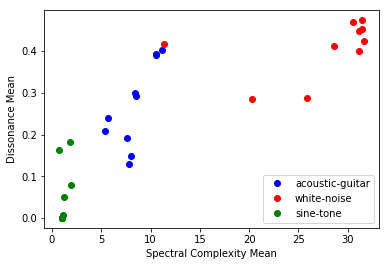

In [7]:
plt.plot(featurePool['acoustic-guitar.complexity.mean'], 
         featurePool['acoustic-guitar.dissonance.mean'], 
         "bo", label = 'acoustic-guitar')

plt.plot(featurePool['white-noise.complexity.mean'], 
         featurePool['white-noise.dissonance.mean'], 
         "ro", label = 'white-noise')

plt.plot(featurePool['sine-tone.complexity.mean'], 
         featurePool['sine-tone.dissonance.mean'], 
         "go", label = 'sine-tone')

plt.rcParams['figure.figsize'] = (17, 8)
plt.legend(loc='best')
plt.xlabel('Spectral Complexity Mean')
plt.ylabel('Dissonance Mean')

Text(0,0.5,'Dissonance Standard Deviation')

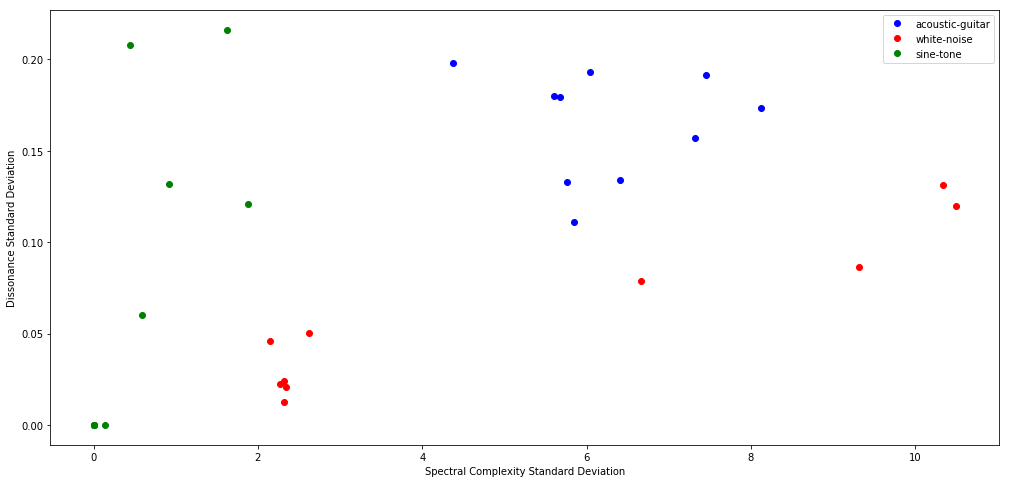

In [8]:
plt.plot(featurePool['acoustic-guitar.complexity.stdev'], 
         featurePool['acoustic-guitar.dissonance.stdev'], 
         "bo", label = 'acoustic-guitar')

plt.plot(featurePool['white-noise.complexity.stdev'], 
         featurePool['white-noise.dissonance.stdev'], 
         "ro", label = 'white-noise')

plt.plot(featurePool['sine-tone.complexity.stdev'], 
         featurePool['sine-tone.dissonance.stdev'], 
         "go", label = 'sine-tone')

plt.rcParams['figure.figsize'] = (17, 8)
plt.legend(loc='best')
plt.xlabel('Spectral Complexity Standard Deviation')
plt.ylabel('Dissonance Standard Deviation')

Text(0,0.5,'Dissonance Standard Deviation')

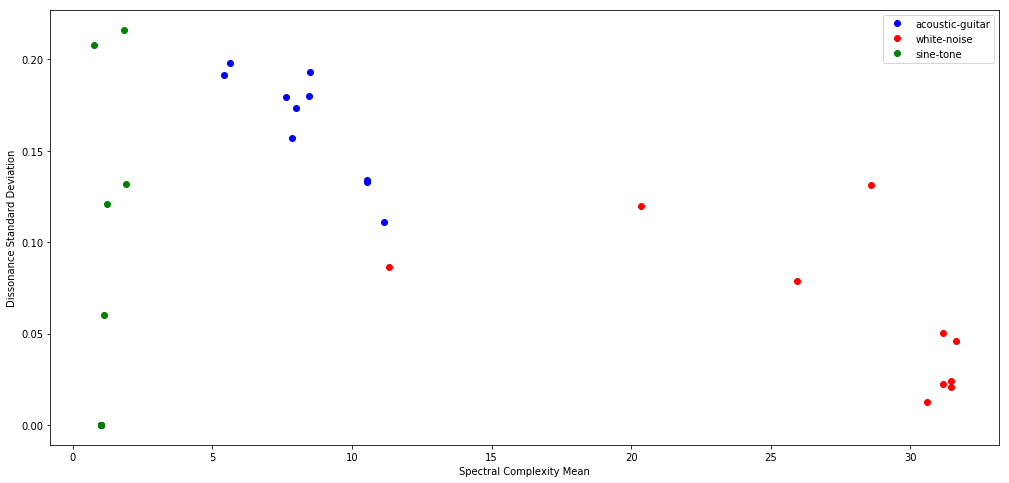

In [9]:
plt.plot(featurePool['acoustic-guitar.complexity.mean'], 
         featurePool['acoustic-guitar.dissonance.stdev'], 
         "bo", label = 'acoustic-guitar')

plt.plot(featurePool['white-noise.complexity.mean'], 
         featurePool['white-noise.dissonance.stdev'], 
         "ro", label = 'white-noise')

plt.plot(featurePool['sine-tone.complexity.mean'], 
         featurePool['sine-tone.dissonance.stdev'], 
         "go", label = 'sine-tone')

plt.rcParams['figure.figsize'] = (17, 8)
plt.legend(loc='best')
plt.xlabel('Spectral Complexity Mean')
plt.ylabel('Dissonance Standard Deviation')

Text(0,0.5,'Dissonance Standard Mean')

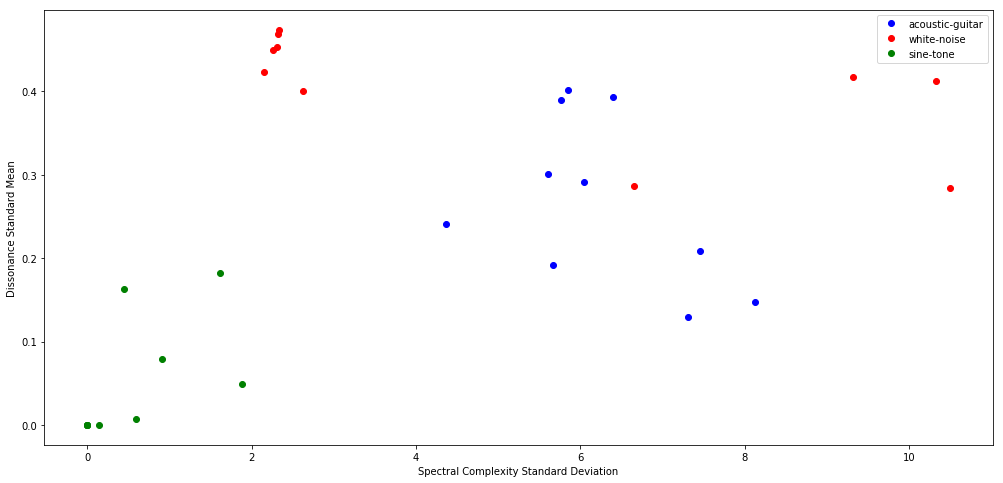

In [10]:
plt.plot(featurePool['acoustic-guitar.complexity.stdev'], 
         featurePool['acoustic-guitar.dissonance.mean'], 
         "bo", label = 'acoustic-guitar')

plt.plot(featurePool['white-noise.complexity.stdev'], 
         featurePool['white-noise.dissonance.mean'], 
         "ro", label = 'white-noise')

plt.plot(featurePool['sine-tone.complexity.stdev'], 
         featurePool['sine-tone.dissonance.mean'], 
         "go", label = 'sine-tone')

plt.rcParams['figure.figsize'] = (17, 8)
plt.legend(loc='best')
plt.xlabel('Spectral Complexity Standard Deviation')
plt.ylabel('Dissonance Standard Mean')